# Прогнозирование температуры стали во время плавки

## 1. Загрузка данных и предварительный анализ

### 1.1 Загрузка библиотек, установки и настройки

In [1]:
#импорты
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import shap


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn import linear_model


from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor as LGBR
from xgboost import XGBRegressor as XGBR
from mlxtend.regressor import StackingCVRegressor


warnings.filterwarnings('ignore')

In [2]:
#директории
local_dir = '/datasets/'
pc_dir = 'C:/Users/Mi/Desktop/dfs_proj/'
#Random state
RANDOM_SEED = 280823

### 1.2 Загрузка данных

#### 1.2.1 Данные электродов

In [3]:
#загрузка данных с электродов
try:
    data_arc = pd.read_csv(local_dir + 'data_arc_new.csv')
except:
    data_arc = pd.read_csv(pc_dir + 'data_arc_new.csv')
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


In [4]:
#приведем названия колонок в удобный вид
data_arc.columns = ['key', 'start_heating', 'end_heating', 'active_power', 'reactive_power']

In [5]:
#информация о датасете
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   start_heating   14876 non-null  object 
 2   end_heating     14876 non-null  object 
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропущенных значений не обнаружено.
Даты содержат неверный формат - object. Для удобства переведем их к datetime.

In [6]:
#перевод столбцов к формату dt
data_arc.start_heating = pd.to_datetime(data_arc.start_heating)
data_arc.end_heating = pd.to_datetime(data_arc.end_heating)

In [7]:
data_arc.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


В данных заметны выбросы в колонках active_power и reactive_power. При этом в reactive_power есть экстремальное значение = -715

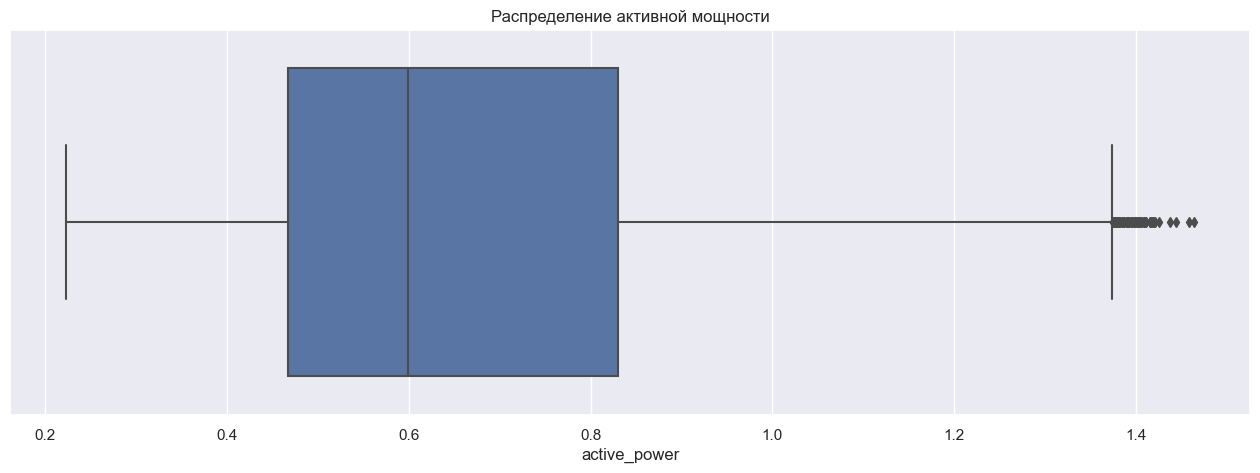

In [8]:
sns.set(rc={'figure.figsize':(16, 5)})
sns.boxplot(x=data_arc['active_power']).set_title('Распределение активной мощности');

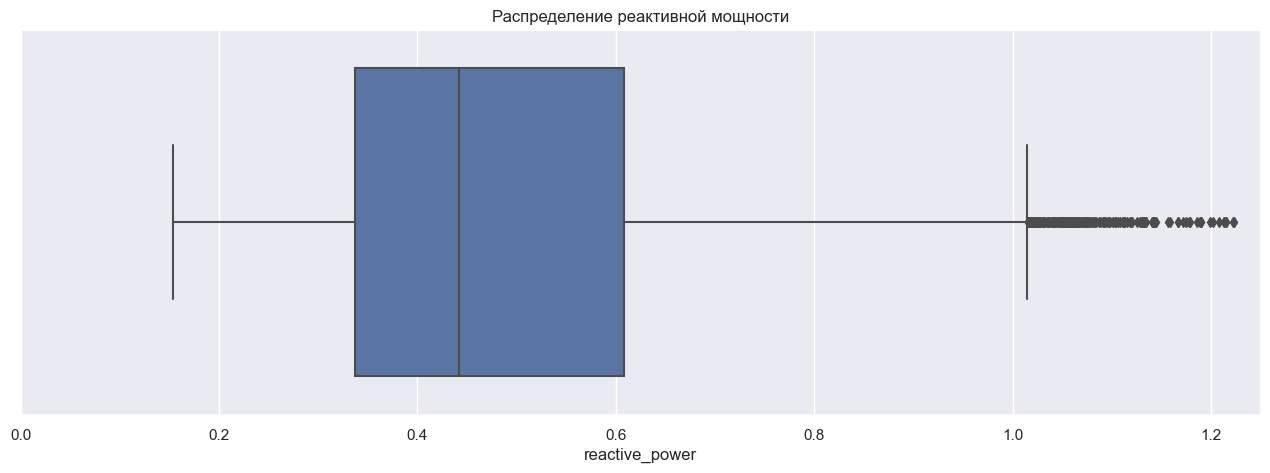

In [9]:
sns.boxplot(x=data_arc.reactive_power).set_title('Распределение реактивной мощности');
plt.xlim(0, 1.25);

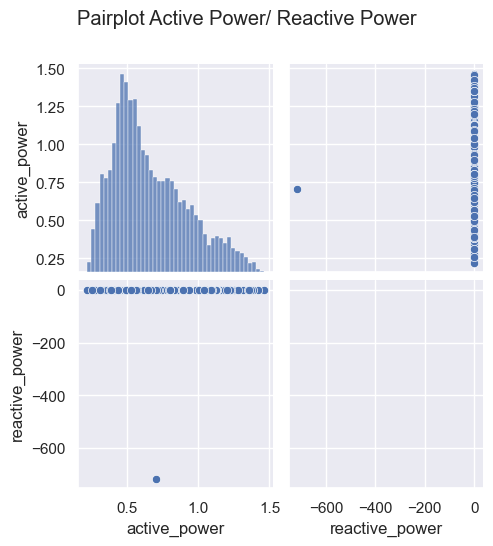

In [10]:
#построение парной диаграммы активной и реактивной мощностей
g = sns.pairplot(data_arc[['active_power', 'reactive_power']])
g.fig.suptitle("Pairplot Active Power/ Reactive Power", y=1.08);

Признаки active_power и reactive_power сильно скоррелированы. Виден явный выброс в данных.

#### 1.2.2 Данные о подаче сыпучих материалов

In [11]:
#загрузка данных
try:
    data_bulk = pd.read_csv(local_dir + 'data_bulk_new.csv')
except:
    data_bulk = pd.read_csv(pc_dir + 'data_bulk_new.csv')
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [12]:
#информация о датасете
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Наблюдается большое количество пропусков в данных. Посмотрим на долю пропусков в датасете.

In [13]:
(data_bulk.isna().mean().to_frame()
 .rename(columns={0: 'Доля пропусков в данных'}).sort_values('Доля пропусков в данных', ascending=False)
)

,Доля пропусков в данных
Bulk 8,0.999680
Bulk 13,0.994247
Bulk 9,0.993928
Bulk 2,0.992969
Bulk 7,0.992010
Bulk 5,0.975391
Bulk 10,0.943752
Bulk 11,0.943432
Bulk 1,0.919463
Bulk 6,0.815916


In [14]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


После первичного EDA колонки с большим количеством пропусков мы удалим из датасета.

#### 1.2.3 Данные о подаче сыпучих материалов (время);

In [15]:
#загрузка данных
try:
    data_bulk_time = pd.read_csv(local_dir + 'data_bulk_time_new.csv')
except:
    data_bulk_time = pd.read_csv(pc_dir + 'data_bulk_time_new.csv')
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Перед нами времена подачи сыпучих материалов.

In [16]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Пропуски в тех же ячейках, где и в data_bulk.

Выведем минимальные и максимальные даты по каждой колонке, чтобы оценить, нет ли выбивающихся значений.

In [17]:
data_bulk_time.drop(['key'], axis=1).apply(pd.to_datetime).min()

Bulk 1    2019-05-03 17:42:46
Bulk 2    2019-05-07 15:39:35
Bulk 3    2019-05-03 20:40:25
Bulk 4    2019-05-03 11:28:48
Bulk 5    2019-05-07 15:19:17
Bulk 6    2019-05-03 19:09:15
Bulk 7    2019-05-07 18:11:01
Bulk 8    2019-07-08 17:14:53
Bulk 9    2019-05-14 11:57:58
Bulk 10   2019-05-06 07:54:02
Bulk 11   2019-05-05 23:43:24
Bulk 12   2019-05-03 11:24:31
Bulk 13   2019-05-05 02:10:21
Bulk 14   2019-05-03 11:14:50
Bulk 15   2019-05-03 11:10:43
dtype: datetime64[ns]

In [18]:
data_bulk_time.drop(['key'], axis=1).apply(pd.to_datetime).max()

Bulk 1    2019-09-05 09:11:32
Bulk 2    2019-08-13 11:47:39
Bulk 3    2019-09-06 12:26:52
Bulk 4    2019-09-05 03:35:21
Bulk 5    2019-09-02 18:16:52
Bulk 6    2019-09-06 16:24:28
Bulk 7    2019-09-05 19:07:49
Bulk 8    2019-07-08 17:14:53
Bulk 9    2019-08-16 09:11:56
Bulk 10   2019-09-04 10:03:22
Bulk 11   2019-09-06 05:03:14
Bulk 12   2019-09-06 15:01:44
Bulk 13   2019-09-01 01:53:02
Bulk 14   2019-09-06 17:26:33
Bulk 15   2019-09-06 17:23:15
dtype: datetime64[ns]

По всей видимости, странных значений даты в сыпучих материалах нет и нам эти даты не понадобятся в работе.

#### 1.2.4 Данные о продувке сплава газом

In [19]:
#загрузка данных
try:
    data_gas = pd.read_csv(local_dir + 'data_gas_new.csv')
except:
    data_gas = pd.read_csv(pc_dir + 'data_gas_new.csv')
data_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [20]:
#приведем названия столбцов к удобным значениям
data_gas.columns = ['key', 'gas_1']

In [21]:
#выведем информацию о датасете
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропуски отсутствуют.

In [22]:
#посмотрим распределение в данных
data_gas.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Присутствуют выбросы в области высоких значений подачи газа.

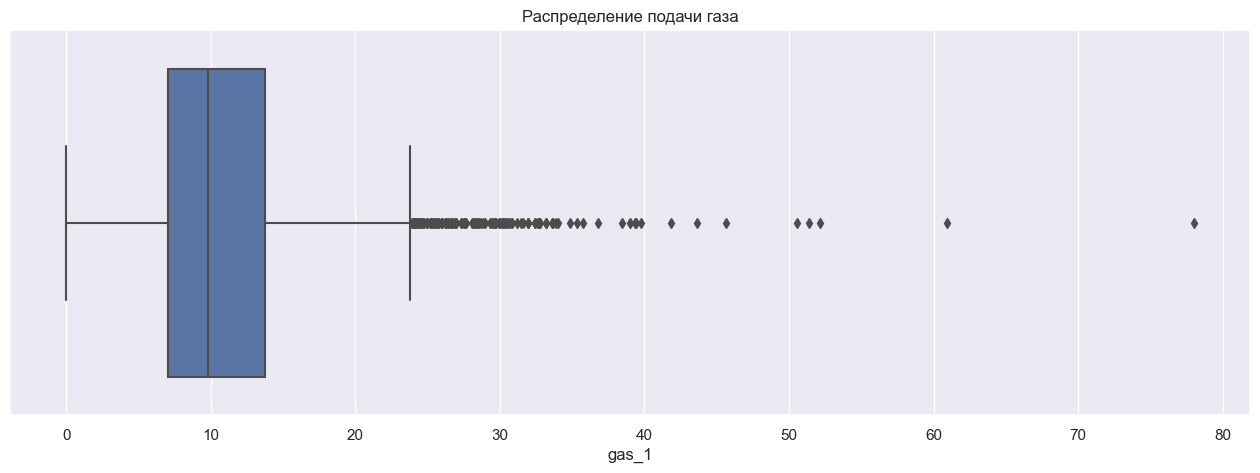

In [23]:
sns.boxplot(x=data_gas['gas_1']).set_title('Распределение подачи газа');

#### 1.2.5 Данные термодатчиков

In [24]:
#загрузка данных
try:
    data_temp = pd.read_csv(local_dir + 'data_temp_new.csv')
except:
    data_temp = pd.read_csv(pc_dir + 'data_temp_new.csv')
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [25]:
#заменим названия колонок
data_temp.columns = ['key', 'measure_time', 'temp']

In [26]:
#выведем информацию по датасету
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   measure_time  18092 non-null  object 
 2   temp          14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [27]:
#переведем measure_time к типу datetime
data_temp['measure_time'] = pd.to_datetime(data_temp['measure_time'])

In [28]:
data_temp.isna().mean()

key             0.000000
measure_time    0.000000
temp            0.189421
dtype: float64

В температурах около 19% пропусков.

In [29]:
data_temp.describe()

,key,temp
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


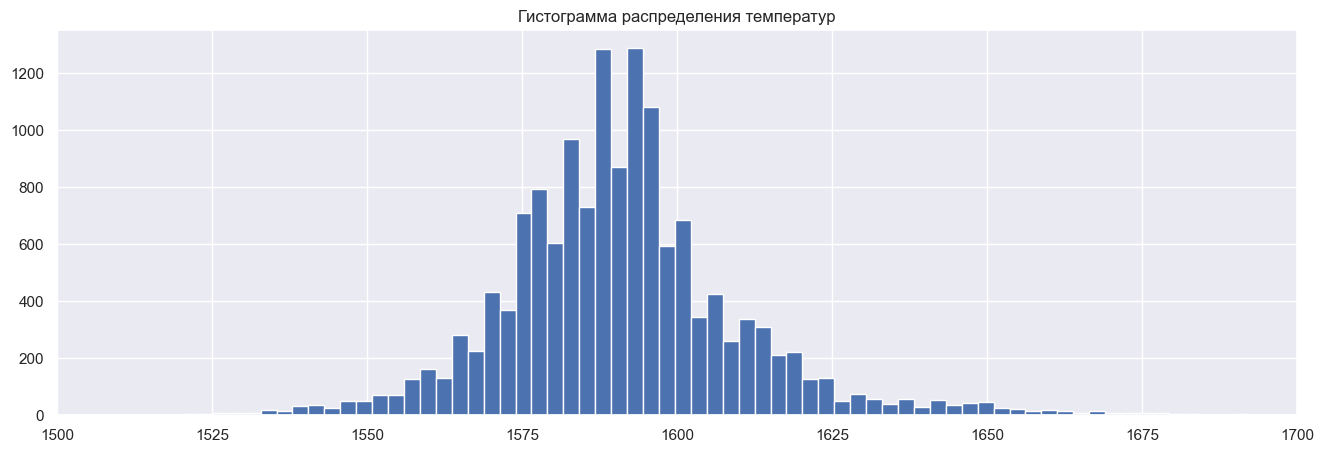

In [30]:
#распределение температур в датасете
data_temp['temp'].hist(bins=200).set_title('Гистограмма распределения температур')
plt.xlim(1500, 1700);

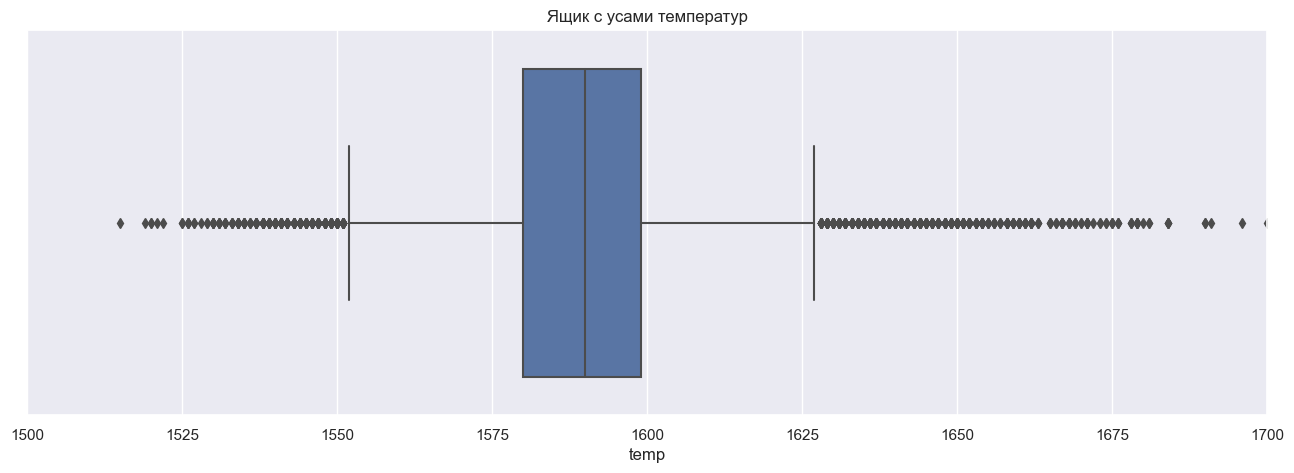

In [31]:
sns.boxplot(x=data_temp.temp).set_title('Ящик с усами температур')
plt.xlim(1500, 1700);

Есть определенное количество явных выбросов в данных.

По словам заказчика все данные с температурой менее 1500 градусов можно убрать - такие данные не относятся к процессу обработки стали.

#### 1.2.6 Данные о подаче проволочных материалов

In [32]:
#загрузка данных
try:
    data_wire = pd.read_csv(local_dir + 'data_wire_new.csv')
except:
    data_wire = pd.read_csv(pc_dir + 'data_wire_new.csv')
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
#посмотрим информацию о датасете
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Во всех колонках кроме Wire 1 и Wire 2 практически все данные являются пропусками

In [34]:
(data_wire.isna().mean().to_frame()
 .rename(columns={0: 'Доля пропусков в данных'}).sort_values('Доля пропусков в данных', ascending=False)
)

,Доля пропусков в данных
Wire 5,0.999675
Wire 7,0.996430
Wire 4,0.995456
Wire 8,0.993833
Wire 9,0.990587
Wire 3,0.979552
Wire 6,0.976306
Wire 2,0.649789
Wire 1,0.008439
key,0.000000


In [35]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


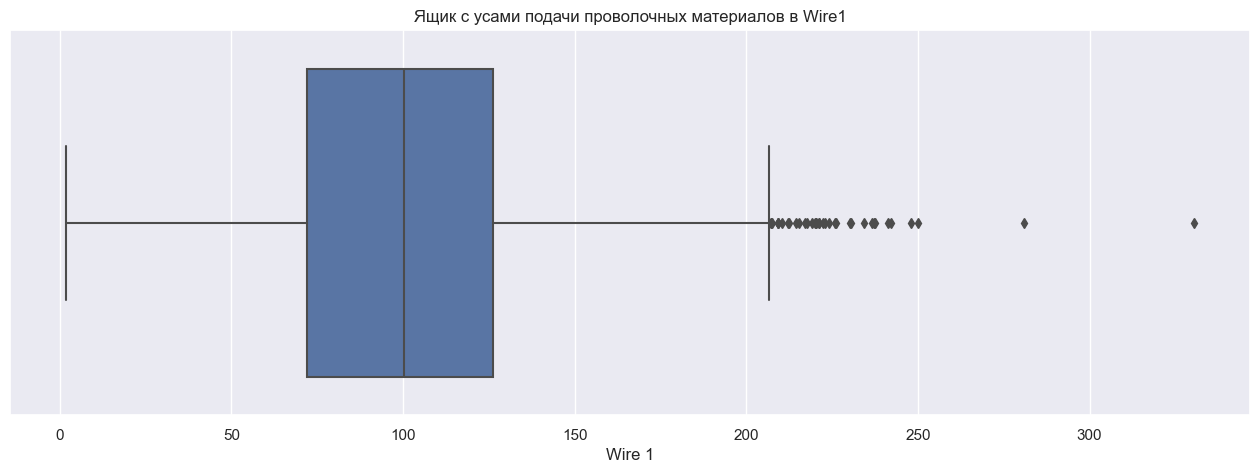

In [36]:
#выбросы в Wire1
sns.boxplot(x=data_wire['Wire 1']).set_title('Ящик с усами подачи проволочных материалов в Wire1');

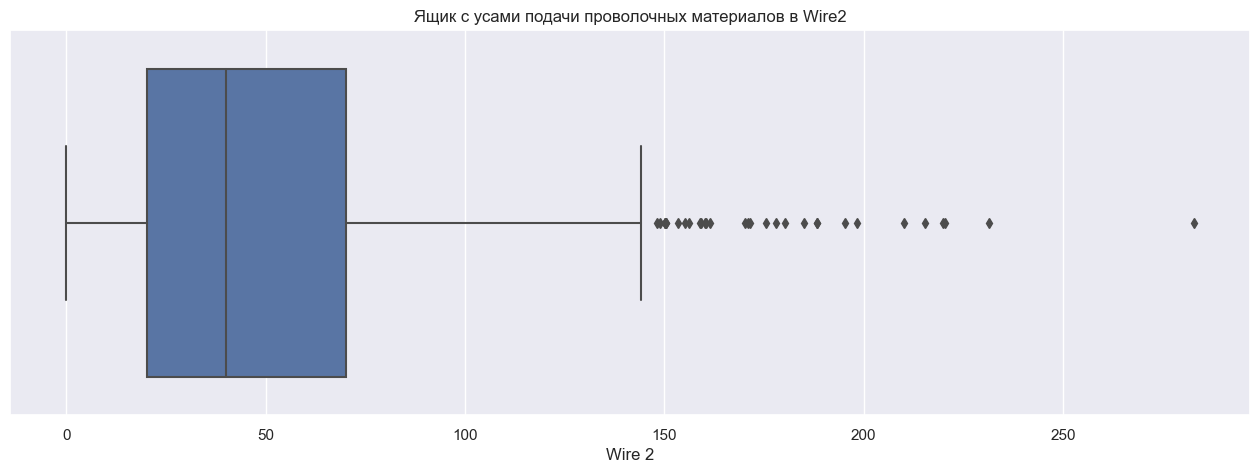

In [37]:
#выбросы в Wire1
sns.boxplot(x=data_wire['Wire 2']).set_title('Ящик с усами подачи проволочных материалов в Wire2');

В Wire 1 и Wire2 также присутствуют выбросы.

In [38]:
data_wire.corr()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,1.000000,-0.083352,-0.005461,-0.084460,0.389064,NaN,0.082274,0.578898,0.323891,-0.012200
Wire 1,-0.083352,1.000000,-0.030892,0.724370,0.054001,NaN,-0.280807,-0.035072,0.068697,0.010104
Wire 2,-0.005461,-0.030892,1.000000,-0.081852,NaN,NaN,-0.265706,NaN,0.250477,0.011019
Wire 3,-0.084460,0.724370,-0.081852,1.000000,0.069854,NaN,-0.221602,-0.056948,NaN,NaN
Wire 4,0.389064,0.054001,NaN,0.069854,1.000000,NaN,0.237456,-0.404865,NaN,NaN
Wire 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,0.082274,-0.280807,-0.265706,-0.221602,0.237456,NaN,1.000000,-0.224093,NaN,NaN
Wire 7,0.578898,-0.035072,NaN,-0.056948,-0.404865,NaN,-0.224093,1.000000,NaN,NaN
Wire 8,0.323891,0.068697,0.250477,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
Wire 9,-0.012200,0.010104,0.011019,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


#### 1.2.7 Данные о подаче проволочных материалов (время).

In [39]:
#загрузка данных
try:
    data_wire_time = pd.read_csv(local_dir + 'data_wire_time_new.csv')
except:
    data_wire_time = pd.read_csv(pc_dir + 'data_wire_time_new.csv')
data_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
data_wire_time.drop(['key'], axis=1).apply(pd.to_datetime).min()

Wire 1   2019-05-03 11:06:19
Wire 2   2019-05-03 13:15:34
Wire 3   2019-05-04 04:34:27
Wire 4   2019-05-07 15:19:17
Wire 5   2019-08-13 06:14:30
Wire 6   2019-05-07 14:46:05
Wire 7   2019-07-27 05:49:05
Wire 8   2019-05-14 11:29:24
Wire 9   2019-05-04 17:21:27
dtype: datetime64[ns]

In [41]:
data_wire_time.drop(['key'], axis=1).apply(pd.to_datetime).max()

Wire 1   2019-09-06 17:10:06
Wire 2   2019-09-06 07:35:40
Wire 3   2019-09-02 07:14:44
Wire 4   2019-08-13 03:16:45
Wire 5   2019-08-13 06:14:30
Wire 6   2019-08-18 19:10:56
Wire 7   2019-08-13 10:25:22
Wire 8   2019-08-16 08:56:23
Wire 9   2019-09-03 12:55:23
dtype: datetime64[ns]

Тут собраны даты внесения проволочных материалов. Явно выпадающих значений не обнаружено.

Эти даты так же не понадобятся в обучении моделей.

**Выводы**:
1. Были загружены данные из 7 файлов: была выведена информация по каждому датасету, таблицы распределений, а также визуализированы распределения некоторых столбцов.
2. В данных были обработаны названия столбцов и типы данных.
3. В данных были найдены пропуски и экстремальные значения.
4. Был сделан вывод, что данные о подаче сыпучих материалов (время) и данные о подаче проволочных материалов (время) не понадобятся при обучении моделей машинного обучения.

На основании изученных материалов был составлен план работы:

## План работы

1. Предварительная очистка данных. Очистка данных от экстремальных значений(удаление экстремального отрицательного значения реактивной мощности и низких температур, а также обьектов, где только одна температура). Выделение признаков в датасете с электродами перед агрегацией и дальнейшая агрегация данных.
2. Обработка пропусков в данных с сыпучими и проволочными материалами, выделение нужных признаков.
3. Обьединение таблиц
4. Разделений выборок на обучающую и тестовую.
5. Генерирование новых признаков(при необходимости).
6. Обработка и очистка обучающей выборки, масштабирование признаков тренировочной и тестовой выборки.
7. Обучение моделей с применением кросс-валидации.
8. Отбор признаков (в том числе выделение важности признаков) и расчет дополнительной метрики (R2).
9. Написание выводов о проделанной работе и финального отчета.

## 2. Подготовка данных

### 2.1 Предварительная очистка данных

Проведем предварительную очистку данных от экстремальных значений, а также выделим необходимые признаки.

**Данные электродов**

In [42]:
#очистим экстремальное значение реактивной мощности, которое не может быть отрицательным значением
data_arc = data_arc.query('reactive_power >= 0')
data_arc.shape[0]

14875

Ушел ровно один выброс.

In [43]:
#введем признак продолжительности нагрева на каждом этапе
data_arc['heating_duration'] = (data_arc['end_heating'] - data_arc['start_heating']).dt.total_seconds()

In [44]:
data_arc.head()

,key,start_heating,end_heating,active_power,reactive_power,heating_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0


In [45]:
#сагрегируем данные по ключу key и выведем суммы мощностей и длительности нагрева в секундах в новые признаки
#а также создадим признак количество циклов нагрева
data_arc_agg = data_arc.groupby('key')\
.agg({'active_power': 'sum', 'reactive_power': 'sum', 'heating_duration': 'sum', 'key': 'count'})\
.rename(columns={'key': 'heating_cycles'})
data_arc_agg

,active_power,reactive_power,heating_duration,heating_cycles
key,,,,
1,3.036730,2.142821,1098.0,5
2,2.139408,1.453357,811.0,4
3,4.063641,2.937457,655.0,5
4,2.706489,2.056992,741.0,4
5,2.252950,1.687991,869.0,4
...,...,...,...,...
3237,2.541872,2.025417,909.0,5
3238,1.374821,1.038103,546.0,3
3239,4.848005,3.541541,1216.0,8


**Данные по температурам**

In [46]:
#Сначала очистим все температуры, которые меньше 1500 градусов цельсия - выбросы, которые нужно отсеить по просьбе заказчика
data_temp = data_temp.query('temp >= 1500')

Нашей целевым признаком будет являться последняя температура по каждой партии. При этом, те партии, где всего одна температура, заказчика не интересуют, так как такие данные неинформативны.

In [47]:
#все индексы, где температур более, чем одна
good_index = data_temp.groupby('key').agg({'temp': 'count'}).query('temp > 1').index
#data_temp с такими индексами
data_temp_clean = data_temp[data_temp['key'].isin(good_index)]
data_temp_clean

,key,measure_time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


In [48]:
#выделим первую и последнюю температуру, а также время между первым и последним измерением партии
data_temp_clean = (
    (data_temp_clean.drop_duplicates('key', keep='first')
    .rename(columns={'measure_time': 'first_measure_time','temp': 'start_temp'}).set_index('key'))
    .join(
        data_temp_clean.drop_duplicates('key', keep='last')
        .rename(columns={'measure_time': 'last_measure_time','temp': 'target_temp'}).set_index('key'))
)
data_temp_clean['measure_time_diff'] = (data_temp_clean['last_measure_time'] - data_temp_clean['first_measure_time'])\
                                                                                    .dt.total_seconds()
data_temp_clean

,first_measure_time,start_temp,last_measure_time,target_temp,measure_time_diff
key,,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,1714.0
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,1265.0
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,1753.0
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,1220.0
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,1536.0
...,...,...,...,...,...
2495,2019-08-10 11:27:47,1570.0,2019-08-10 11:50:47,1591.0,1380.0
2496,2019-08-10 11:56:48,1554.0,2019-08-10 12:25:13,1591.0,1705.0
2497,2019-08-10 12:37:26,1571.0,2019-08-10 12:53:28,1589.0,962.0


In [49]:
#оставим только необходимые колонки
data_temp_clean = data_temp_clean[['start_temp', 'target_temp', 'measure_time_diff']]
data_temp_clean

,start_temp,target_temp,measure_time_diff
key,,,
1,1571.0,1613.0,1714.0
2,1581.0,1602.0,1265.0
3,1596.0,1599.0,1753.0
4,1601.0,1625.0,1220.0
5,1576.0,1602.0,1536.0
...,...,...,...
2495,1570.0,1591.0,1380.0
2496,1554.0,1591.0,1705.0
2497,1571.0,1589.0,962.0


**Выводы**:
1. Перед обьединением таблиц было удален элемент с экстремальной реактивной мощностью в данных об электродах.
2. Данные по электродам были сагрегированы по ключу key. Были добавлены признаки - количество циклов нагрева и суммарная длительность нагрева.
3. В таблице по температурам удалены экстремальные значения (с температурой ниже 1500 градусов), а также те партии, где менее 2 измеренных температур.
4. В финальной таблице по температуре оставили лишь необходимые признаки (начальную температуру, разница между временем измерения) и целевой признак.


### 2.2 Обработка пропусков в данных, выделение нужных признаков.

In [50]:
#для удобства переведем во всех данных ключ key в индекс таблицы
#сделаем так, чтобы в подаче газа key был индексом
data_gas = data_gas.set_index('key')
data_gas

,gas_1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692
...,...
3237,5.543905
3238,6.745669
3239,16.023518


**Данные о подаче сыпучих материалов**

In [51]:
#удалим данные, где пропусков более 82%
#удаление Bulk6 приводило к ухудшению предсказаний модели, было решено оставить
data_bulk_clean = data_bulk[['Bulk 6','Bulk 4', 'Bulk 3', 'Bulk 15', 'Bulk 12', 'Bulk 14', 'key']].set_index('key')
data_bulk_clean.head()

,Bulk 6,Bulk 4,Bulk 3,Bulk 15,Bulk 12,Bulk 14
key,,,,,,
1,NaN,43.0,NaN,154.0,206.0,150.0
2,NaN,73.0,NaN,154.0,206.0,149.0
3,NaN,34.0,NaN,153.0,205.0,152.0
4,NaN,81.0,NaN,154.0,207.0,153.0
5,NaN,78.0,NaN,152.0,203.0,151.0


In [52]:
#заполним пропуски нулями - это будет означать, что сыпучий материал не подавался в котел
data_bulk_clean = data_bulk_clean.fillna(0)
data_bulk_clean.head()

,Bulk 6,Bulk 4,Bulk 3,Bulk 15,Bulk 12,Bulk 14
key,,,,,,
1,0.0,43.0,0.0,154.0,206.0,150.0
2,0.0,73.0,0.0,154.0,206.0,149.0
3,0.0,34.0,0.0,153.0,205.0,152.0
4,0.0,81.0,0.0,154.0,207.0,153.0
5,0.0,78.0,0.0,152.0,203.0,151.0


**Данные о подаче проволочных материалов**

In [53]:
#оставим только те данные, где количество пропусков менее 80%
data_wire_clean = data_wire[['Wire 1', 'Wire 2', 'key']].set_index('key')
data_wire_clean.head()

,Wire 1,Wire 2
key,,
1,60.059998,NaN
2,96.052315,NaN
3,91.160157,NaN
4,89.063515,NaN
5,89.238236,9.11456


In [54]:
#заполним пропуски нулями - это будет означать, что проволочный материал не подавался в котел
data_wire_clean = data_wire_clean.fillna(0)
data_wire_clean.head()

,Wire 1,Wire 2
key,,
1,60.059998,0.00000
2,96.052315,0.00000
3,91.160157,0.00000
4,89.063515,0.00000
5,89.238236,9.11456


### 2.3 Объединение таблиц

In [55]:
#Обьединим таблицы методом
#Воспользуемся методом INNER JOIN, чтобы потом не обрабатывать пропуски в данных повторно

data_full = data_temp_clean.join(data_arc_agg, how='inner')\
                        .join(data_gas, how='inner')\
                        .join(data_bulk_clean, how='inner')\
                        .join(data_wire_clean, how='inner')\

data_full

,start_temp,target_temp,measure_time_diff,active_power,reactive_power,heating_duration,heating_cycles,gas_1,Bulk 6,Bulk 4,Bulk 3,Bulk 15,Bulk 12,Bulk 14,Wire 1,Wire 2
key,,,,,,,,,,,,,,,,
1,1571.0,1613.0,1714.0,3.036730,2.142821,1098.0,5,29.749986,0.0,43.0,0.0,154.0,206.0,150.0,60.059998,0.00000
2,1581.0,1602.0,1265.0,2.139408,1.453357,811.0,4,12.555561,0.0,73.0,0.0,154.0,206.0,149.0,96.052315,0.00000
3,1596.0,1599.0,1753.0,4.063641,2.937457,655.0,5,28.554793,0.0,34.0,0.0,153.0,205.0,152.0,91.160157,0.00000
4,1601.0,1625.0,1220.0,2.706489,2.056992,741.0,4,18.841219,0.0,81.0,0.0,154.0,207.0,153.0,89.063515,0.00000
5,1576.0,1602.0,1536.0,2.252950,1.687991,869.0,4,5.413692,0.0,78.0,0.0,152.0,203.0,151.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,1380.0,3.168133,2.210936,723.0,4,7.125735,0.0,0.0,21.0,223.0,256.0,129.0,89.150879,0.00000
2496,1554.0,1591.0,1705.0,4.174918,2.872031,940.0,6,9.412616,0.0,63.0,0.0,226.0,256.0,129.0,114.179527,0.00000
2497,1571.0,1589.0,962.0,3.605239,2.452092,569.0,3,6.271699,0.0,85.0,0.0,226.0,230.0,124.0,94.086723,9.04800


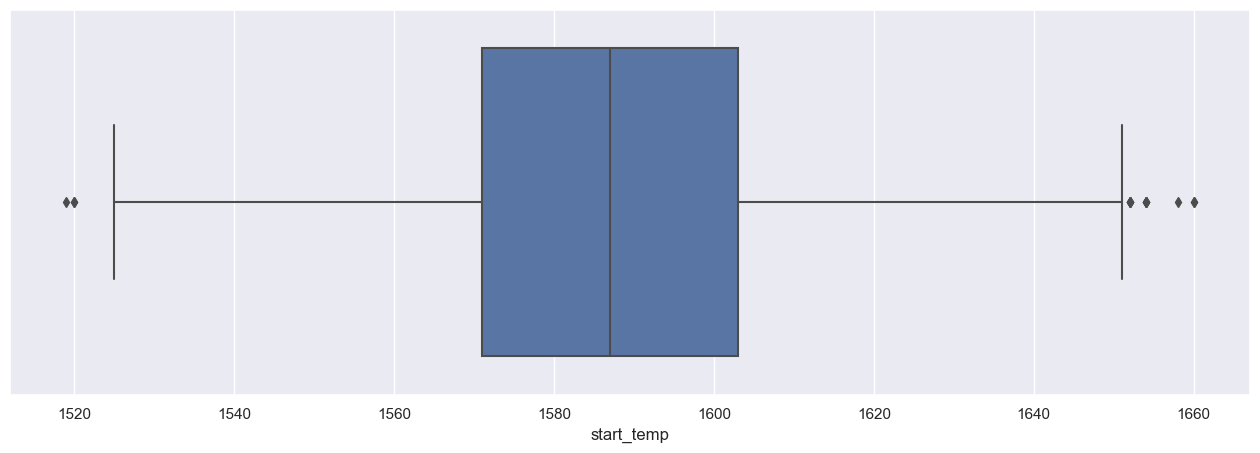

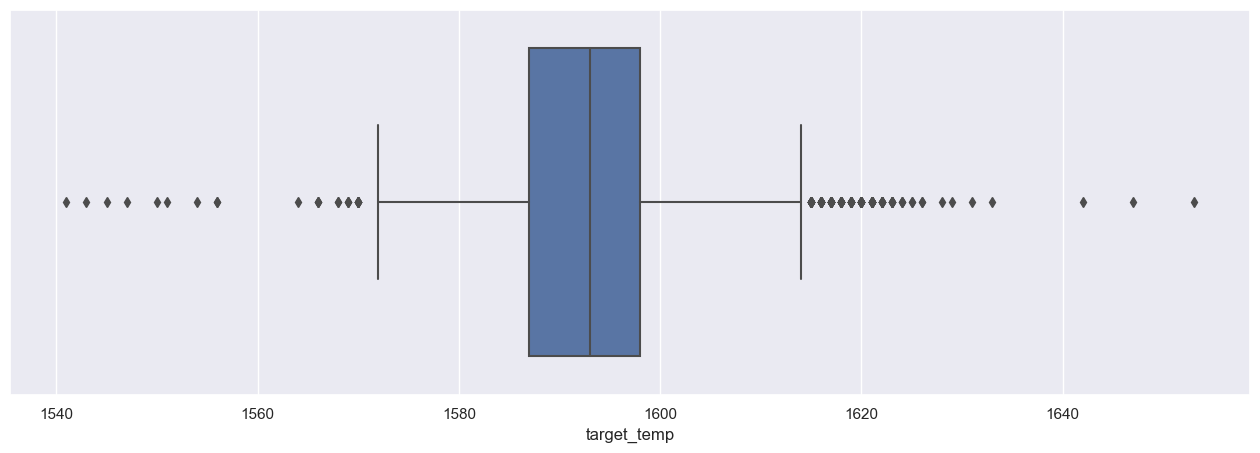

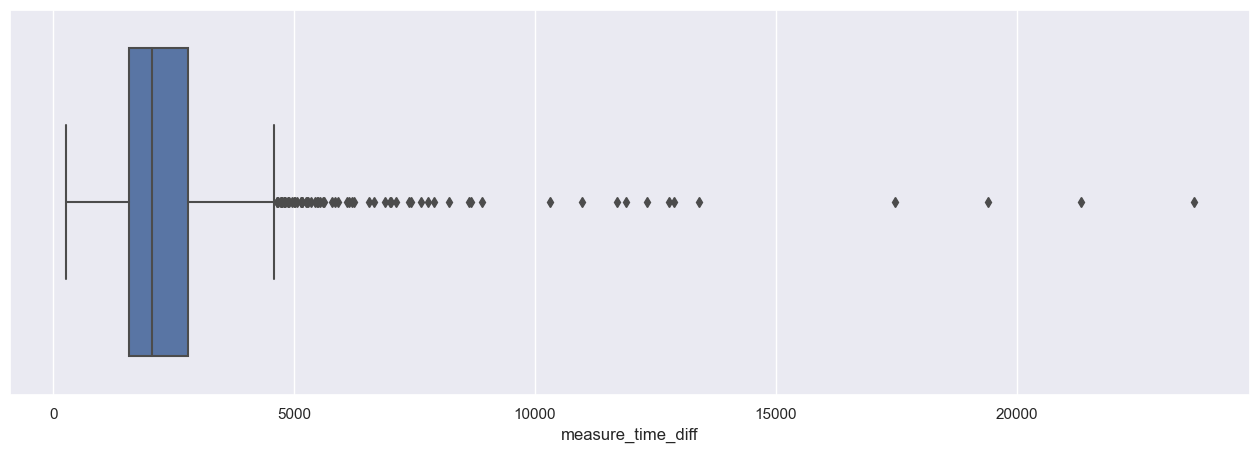

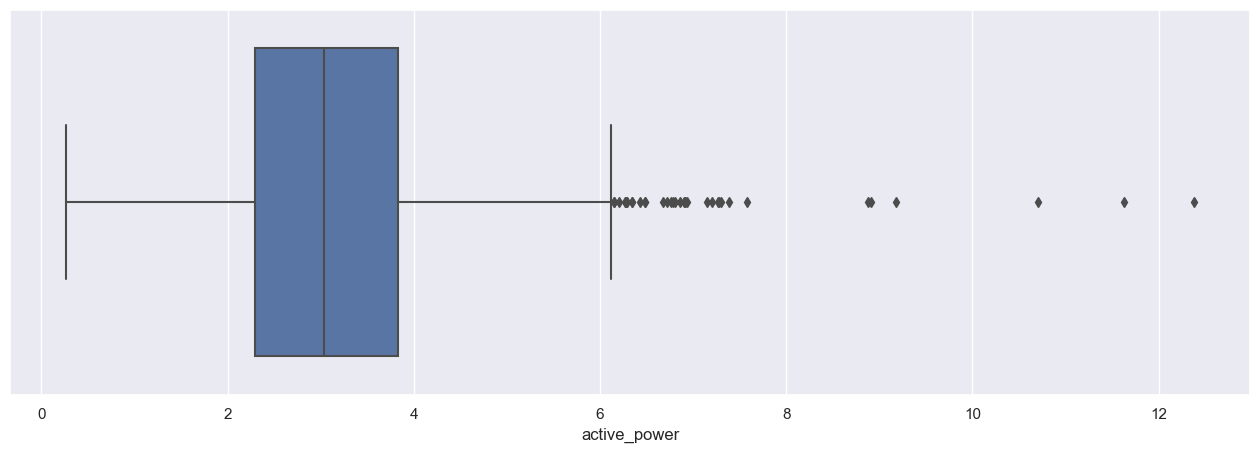

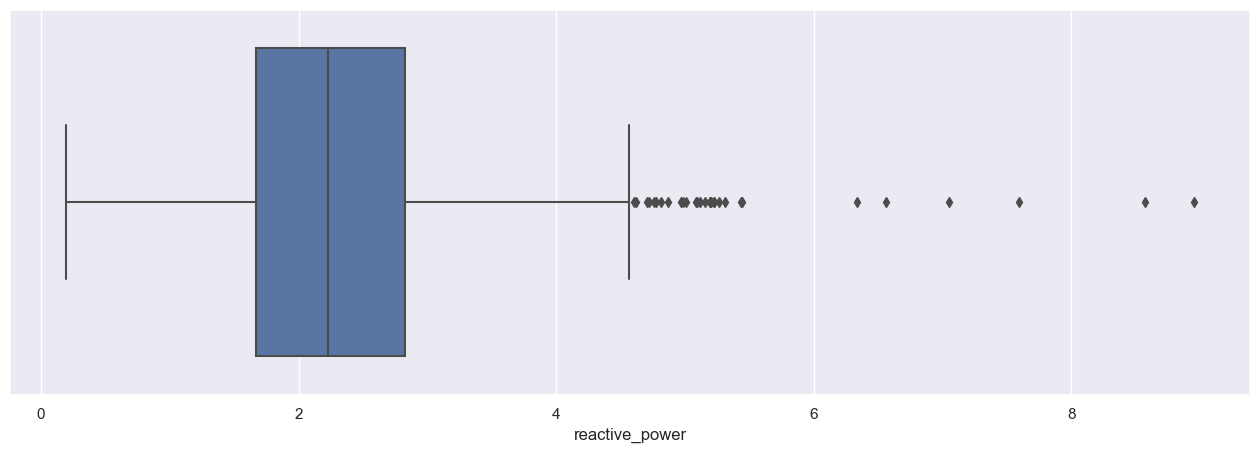

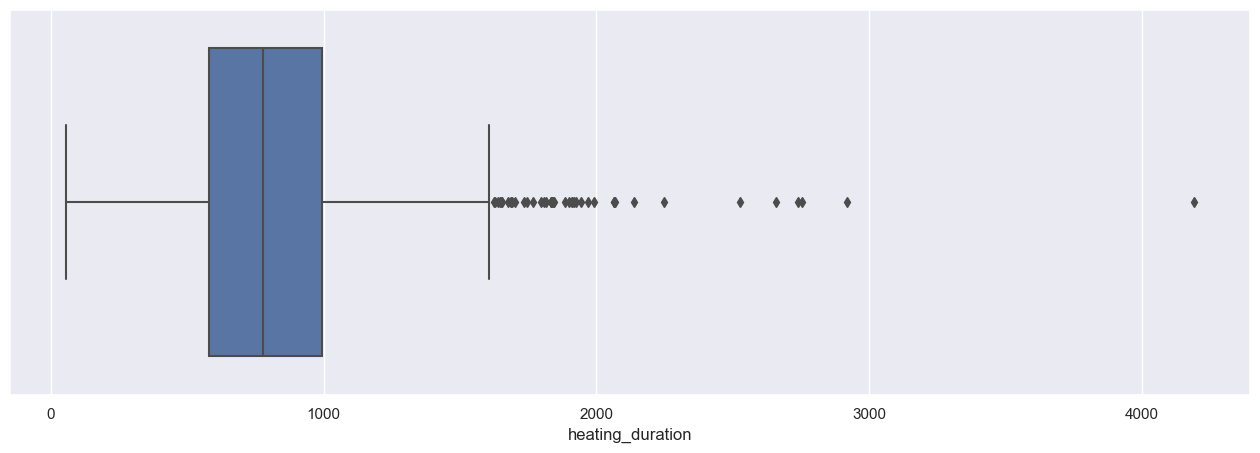

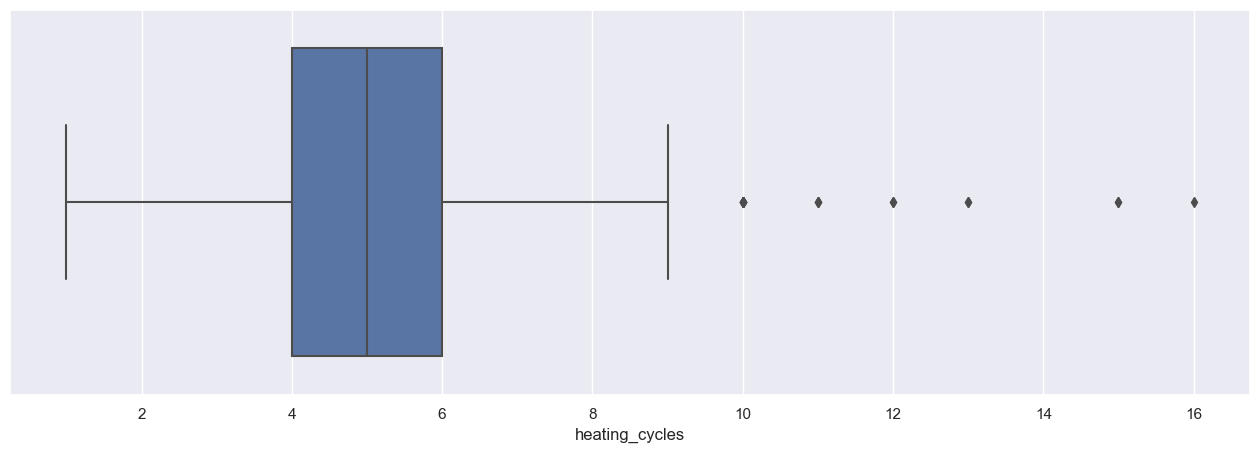

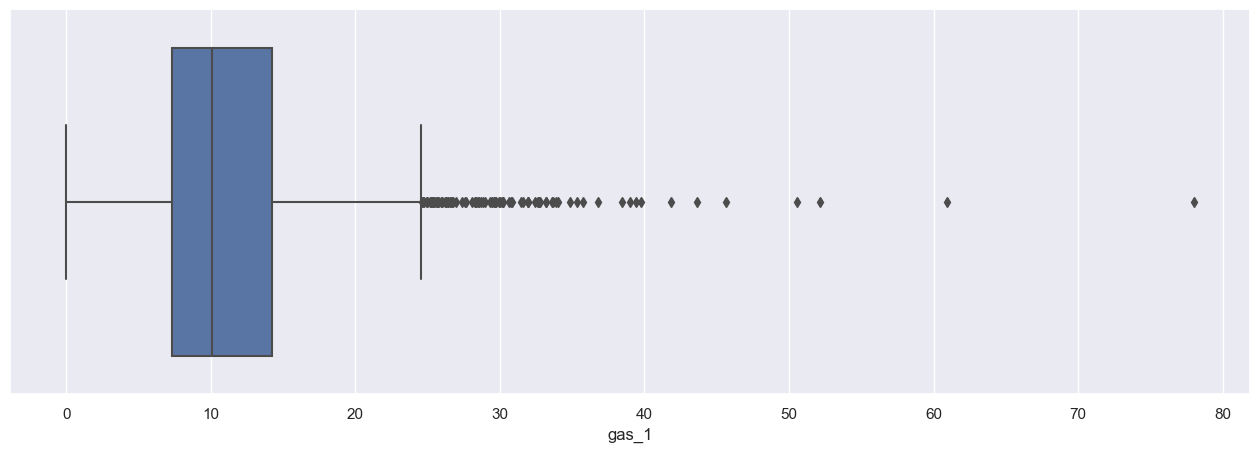

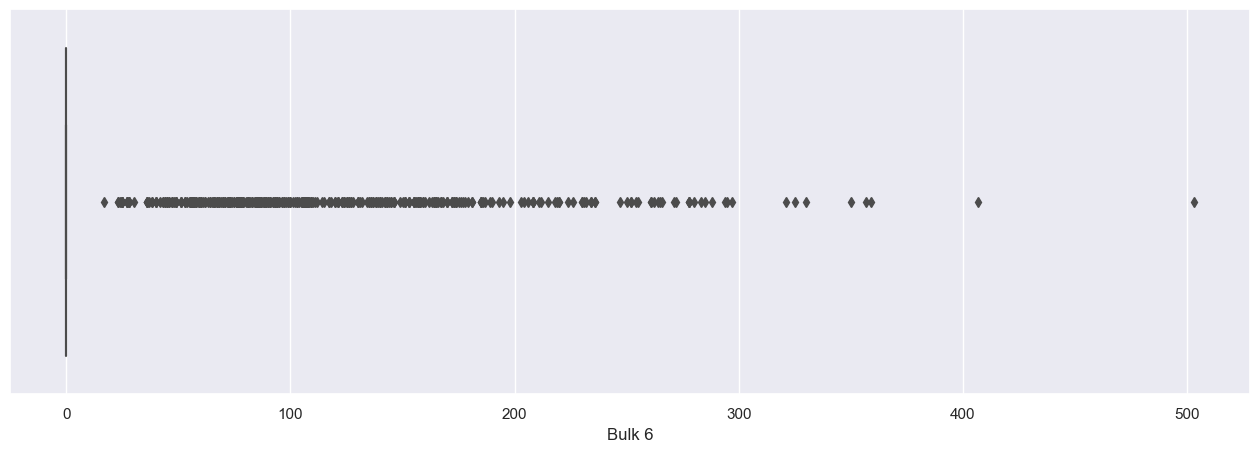

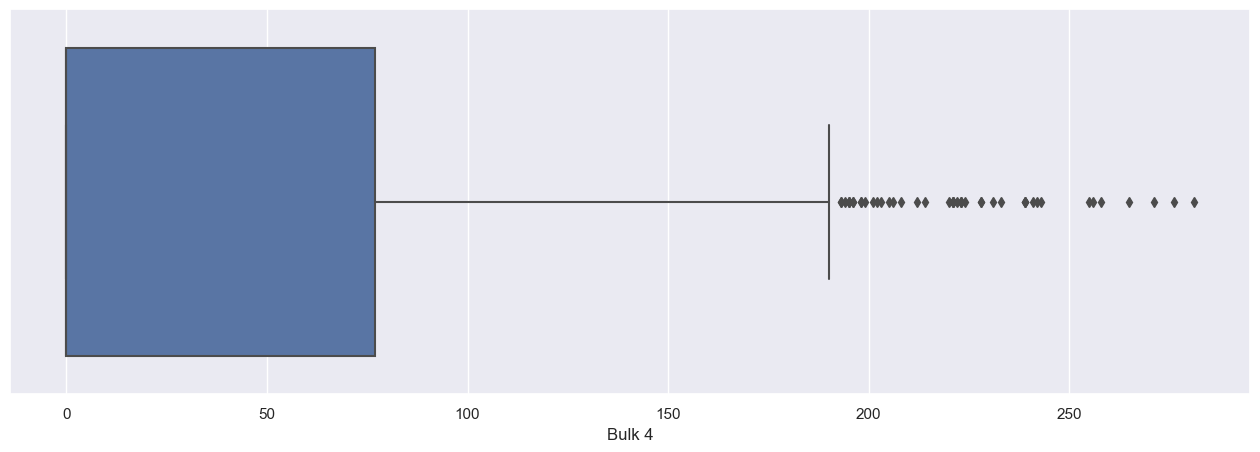

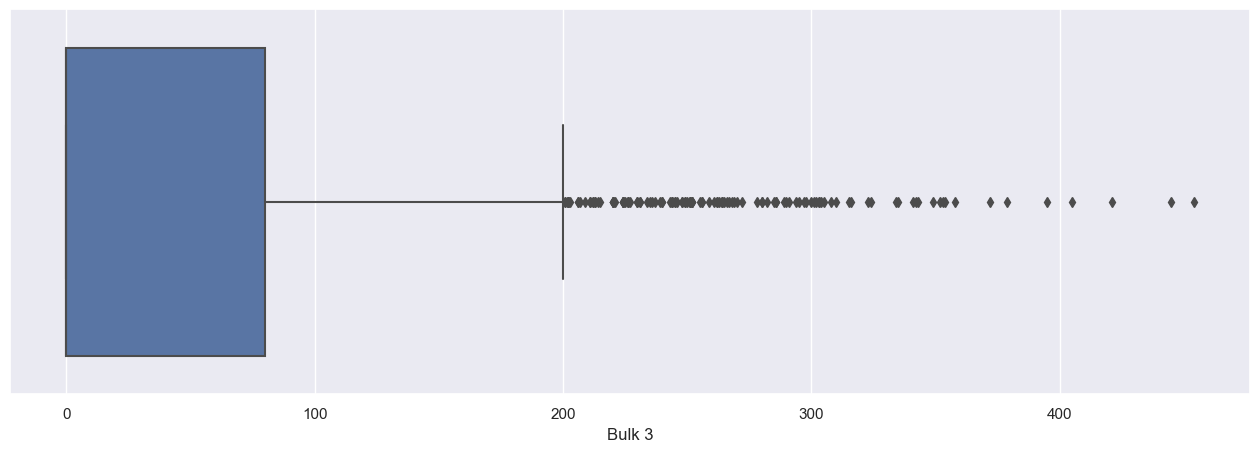

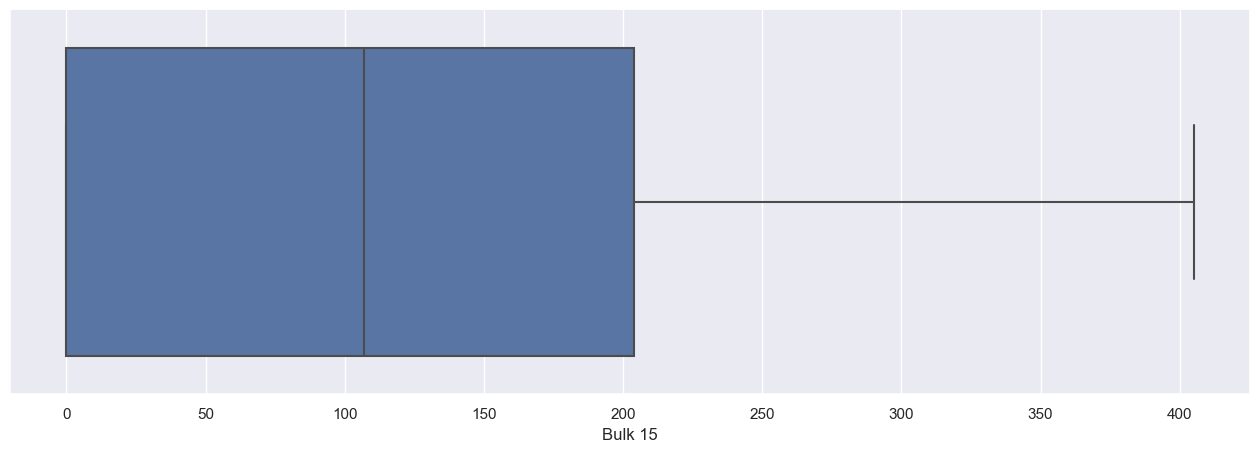

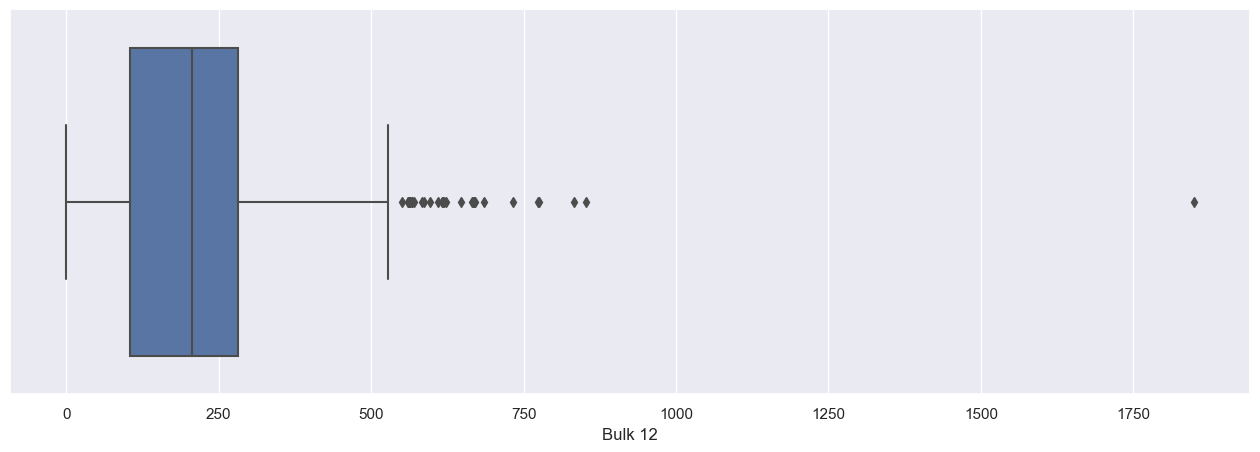

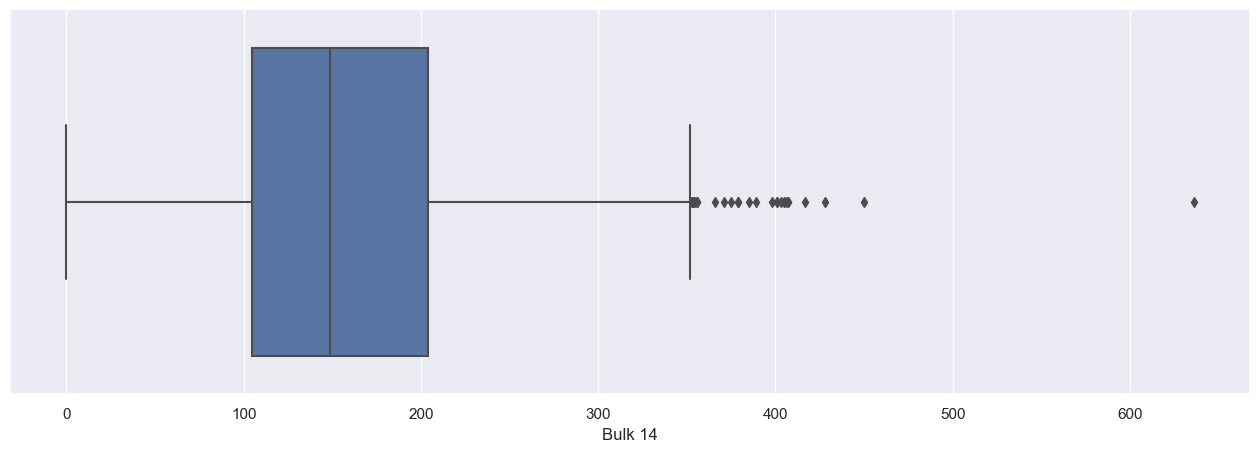

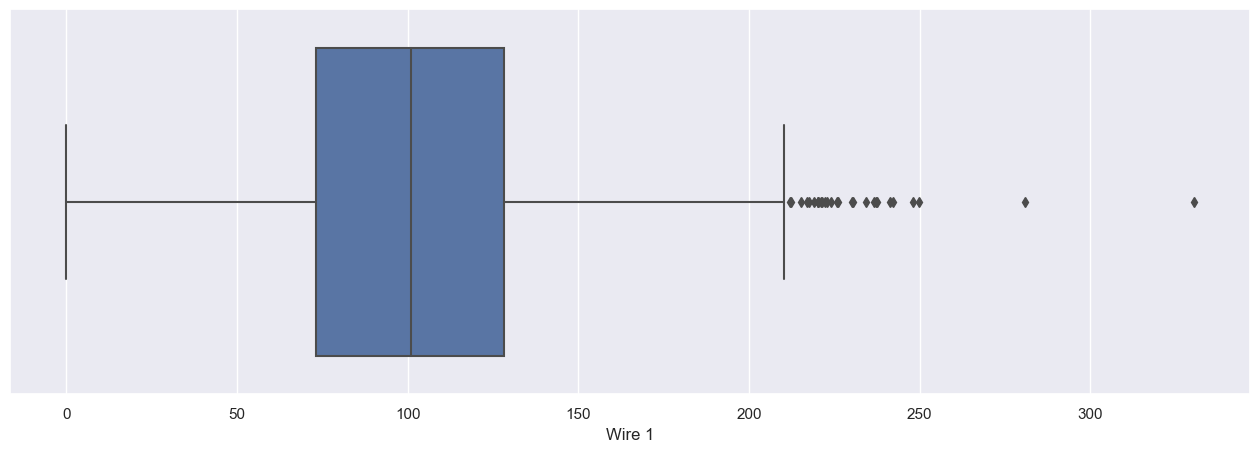

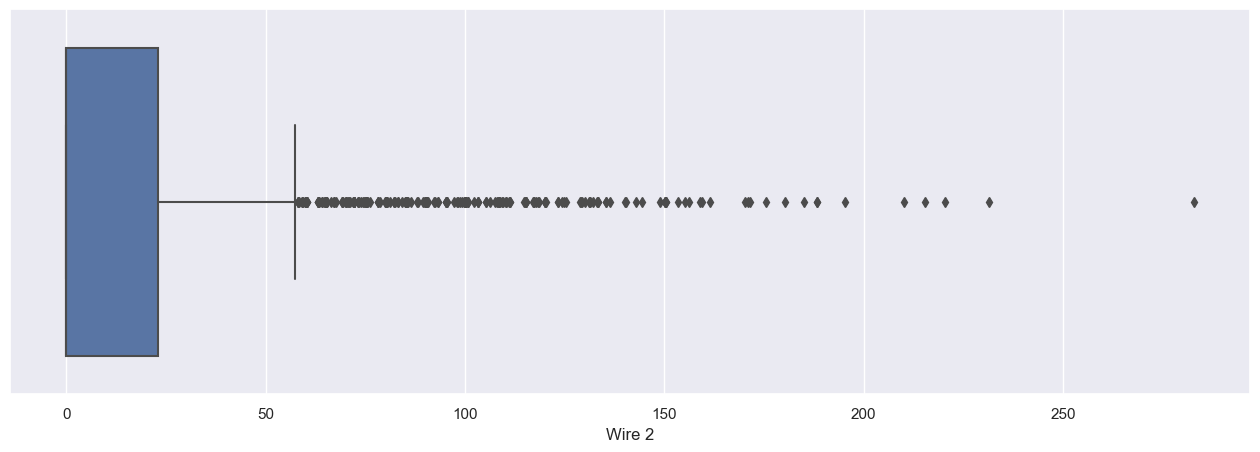

In [56]:
#Выведем боксплоты всех признаков в датасете
for c in data_full.columns:
    sns.boxplot(x=data_full[c])
    plt.show()

Видны выбросы во многих признаках, и их следует очистить перед обучением моделей
(есть некоторое некорректное отображение боксплотов у проволочных и сыпучих материалов, связанное с большим количеством нулевых значений)

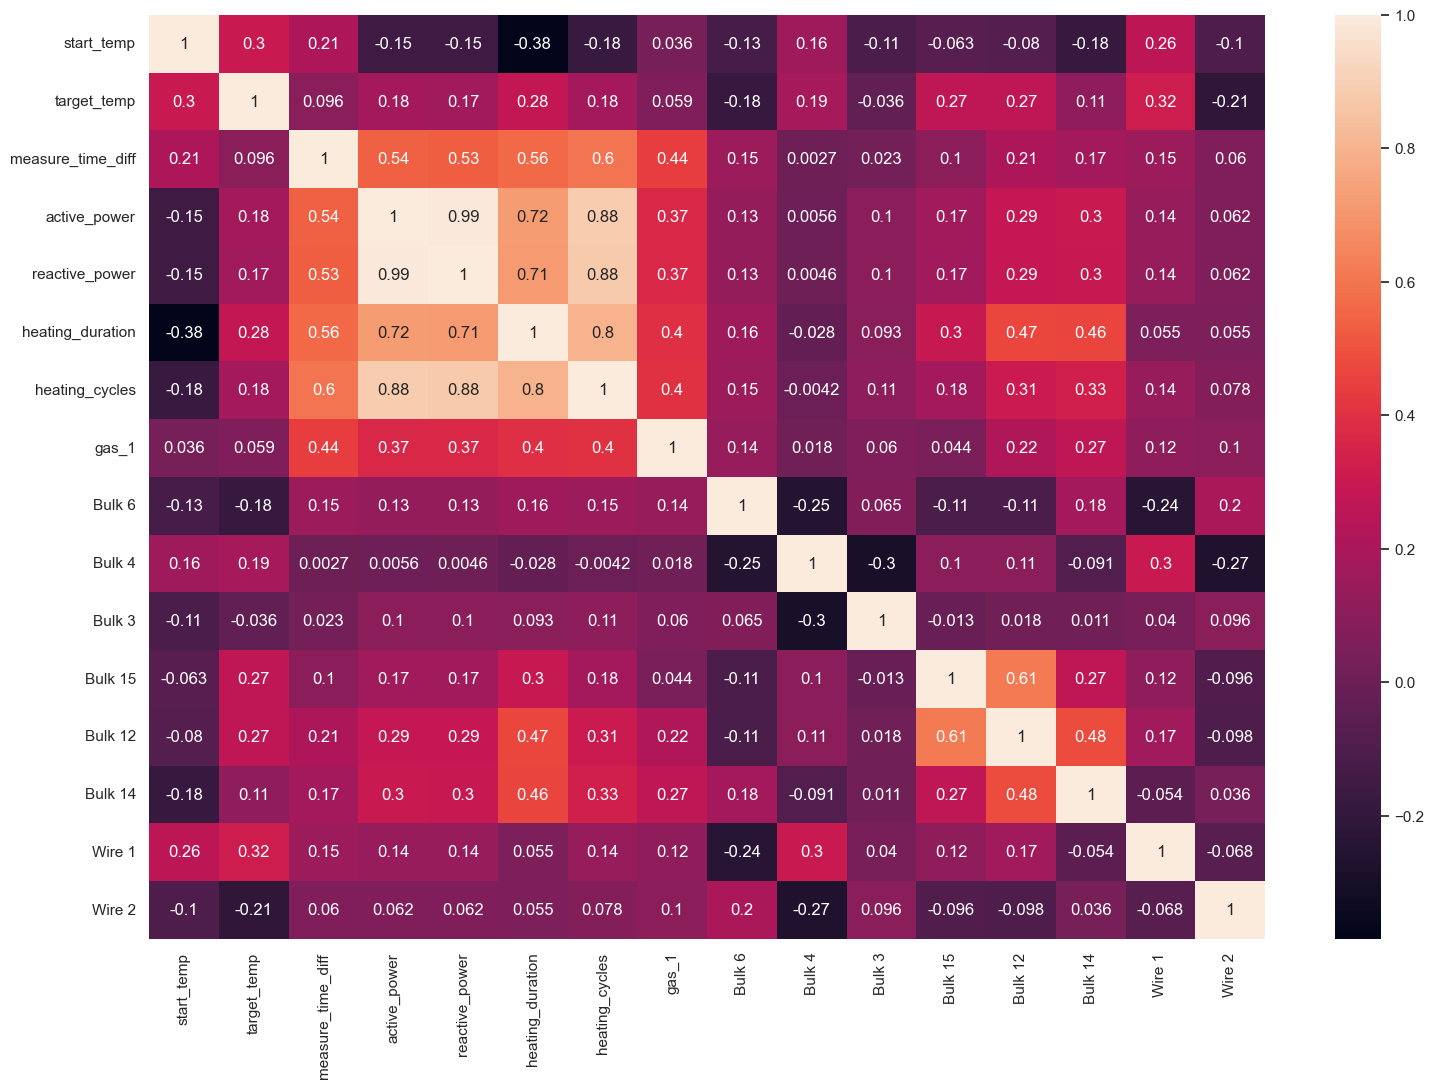

In [57]:
#выведем тепловую карту всех корреляций в датасете
plt.subplots(figsize=(18,12))
sns.heatmap(data_full.corr(), annot=True);

Наблюдается сильная корреляция активной и реактивной мощности. Также заметна корреляция этих признаков с признаком - heating_cycles.

**Выводы**:
1. Таблицы были объединены в финальную таблицу data_full.
2. Были выведены ящики с усами для каждого признака. В признаках были обнаружены выбросы данных.
3. Была построена тепловая карта корреляций.

### 2.4 Генерирование новых признаков

Признаки Активной и Реактивной мощности сильно скоррелированны, можно заменить их на сумарную мощность.

Активная, реактивная и суммарная мощности связаны следующим уравнением:

$$
S = \sqrt{P^{2} + Q^{2}}
$$

где P - активная мощность
Q - реактивная мощность
S - суммарная мощность

In [58]:
data_full['sum_power'] = np.sqrt(data_full['active_power']**2 + data_full['reactive_power']**2)
data_full = data_full.drop(columns=['active_power', 'reactive_power'])
data_full.head()

,start_temp,target_temp,measure_time_diff,heating_duration,heating_cycles,gas_1,Bulk 6,Bulk 4,Bulk 3,Bulk 15,Bulk 12,Bulk 14,Wire 1,Wire 2,sum_power
key,,,,,,,,,,,,,,,
1,1571.0,1613.0,1714.0,1098.0,5,29.749986,0.0,43.0,0.0,154.0,206.0,150.0,60.059998,0.00000,3.716640
2,1581.0,1602.0,1265.0,811.0,4,12.555561,0.0,73.0,0.0,154.0,206.0,149.0,96.052315,0.00000,2.586371
3,1596.0,1599.0,1753.0,655.0,5,28.554793,0.0,34.0,0.0,153.0,205.0,152.0,91.160157,0.00000,5.014163
4,1601.0,1625.0,1220.0,741.0,4,18.841219,0.0,81.0,0.0,154.0,207.0,153.0,89.063515,0.00000,3.399456
5,1576.0,1602.0,1536.0,869.0,4,5.413692,0.0,78.0,0.0,152.0,203.0,151.0,89.238236,9.11456,2.815155


### 2.5 Разделениe выборок на обучающую и тестовую

In [59]:
#Отделим признаки и таргет
features = data_full.drop(columns='target_temp')
target = data_full['target_temp']
features.shape

(2329, 14)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_SEED)

In [61]:
print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (1746, 14)
Размер тестовой выборки: (583, 14)


Выборки поделены на обучающую и тестовую в соотношении 75:25. Размер обучающей выборки после разделения 1746 строк и 14 признаков.

### 2.6 Предобработка признаков

#### 2.6.1 Очистка от выбросов

По требованию заказчика в обучающей выборке должно остаться не менее 1700 элементов.

Лучшие значения метрики получились при таком способе очистки - выбросами считалось все ниже 0.2% квантиля и 99.9%

In [62]:
#очистка от выбросов
X_train = X_train[~((X_train < X_train.quantile(q=0.002)) | (X_train > X_train.quantile(q=0.999))).any(axis=1)]
y_train = y_train[X_train.index]

In [63]:
X_train.shape

(1704, 14)

#### 2.6.2 Масштабирование признаков

In [64]:
#Масштабирование признаков в тренеровочной выборке c помощью StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_train.head()

,start_temp,measure_time_diff,heating_duration,heating_cycles,gas_1,Bulk 6,Bulk 4,Bulk 3,Bulk 15,Bulk 12,Bulk 14,Wire 1,Wire 2,sum_power
0,0.738091,0.547887,1.298601,0.854643,-0.036945,1.925963,-0.655852,1.339581,0.976762,1.324447,0.806183,0.165522,0.899538,0.790893
1,-0.345131,0.576178,0.797116,2.166634,0.085460,0.829979,-0.655852,-0.633857,-0.201513,-0.546374,0.346966,-1.214739,1.856870,1.175170
2,-0.128486,-0.725194,-0.588235,-1.113345,-0.879375,-0.396037,-0.655852,-0.633857,-1.439296,-1.372708,0.602086,-0.035579,-0.528235,-1.224718
3,-0.388460,0.795014,0.693685,0.854643,-0.719744,-0.396037,-0.655852,4.083470,0.952958,2.011957,1.303668,0.489750,-0.528235,0.448358
4,0.868077,0.234193,0.116978,0.198647,-0.723298,-0.396037,1.672174,-0.633857,-1.439296,1.793805,0.653110,0.721270,-0.528235,-0.478432


In [65]:
#Масштабирование признаков в тестовой выборке
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)
X_test.head()

,start_temp,measure_time_diff,heating_duration,heating_cycles,gas_1,Bulk 6,Bulk 4,Bulk 3,Bulk 15,Bulk 12,Bulk 14,Wire 1,Wire 2,sum_power
0,-1.558339,-0.528823,0.725028,0.198647,-0.480115,-0.396037,3.435311,-0.633857,-0.213415,-0.010909,-0.635249,-0.162991,-0.528235,-0.721777
1,-1.211708,-0.285024,1.179498,0.854643,-0.528989,-0.396037,0.799164,1.447714,-1.439296,-1.372708,-1.936364,-0.557206,-0.528235,0.779765
2,-0.648433,-0.769294,-0.531817,-0.457349,-1.092823,-0.396037,0.148686,-0.120222,1.000565,0.319625,-0.418396,0.510006,-0.528235,-0.180757
3,-1.818312,-0.134418,1.248453,-0.457349,-1.266638,-0.396037,-0.655852,1.353098,1.000565,3.043222,0.589330,-0.070427,-0.528235,0.246619
4,0.261473,-0.003781,0.088770,-1.113345,0.799002,2.966219,-0.655852,-0.633857,0.334067,1.331058,1.979737,-0.905683,0.234998,-1.401784



1. Данные были очищены от выбросов
2. Было произведено масштабирование данных с помощью StandardScaler

## 3. Обучeние моделей

### 3.1 Dummy model (baseline)

In [66]:
# для проверки модели на адекватность инициализируем дамми регрессор
dummy = DummyRegressor(strategy='mean')

In [67]:
dummy.fit(X_train, y_train)

DummyRegressor()

In [68]:
dummy_prediction = dummy.predict(X_test)

In [69]:
print('MAE dummy модели:', round(mean_absolute_error(y_test, dummy_prediction), 2))

MAE dummy модели: 8.29


### 3.2 Linear regression

In [70]:
linear = linear_model.LinearRegression(n_jobs = -1)
lin_params = {}
lin_Grid = GridSearchCV(linear, cv=3, param_grid=lin_params, scoring='neg_mean_absolute_error')
lin_Grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LinearRegression(n_jobs=-1), param_grid={},
             scoring='neg_mean_absolute_error')

In [71]:
lin_Grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LinearRegression(n_jobs=-1), param_grid={},
             scoring='neg_mean_absolute_error')

In [72]:
print('MAE на кросс-валидации для линейной регрессии', round(-lin_Grid.best_score_, 2))

MAE на кросс-валидации для линейной регрессии 5.91


### 3.3 SGD

In [73]:
SGD = linear_model.SGDRegressor(random_state=RANDOM_SEED)
SGD_params = {'penalty': ['l2', 'l1', 'elasticnet'],
             'alpha': [0.0001, 0.001, 0.01, 0.1],
             'l1_ratio': [0.01, 0.1, 0.3, 0.6]}
SGD_Grid = GridSearchCV(SGD, cv=3, param_grid=SGD_params, scoring='neg_mean_absolute_error')

In [74]:
%%time
SGD_Grid.fit(X_train, y_train)

CPU times: total: 2.12 s
Wall time: 1.18 s


GridSearchCV(cv=3, estimator=SGDRegressor(random_state=280823),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'l1_ratio': [0.01, 0.1, 0.3, 0.6],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             scoring='neg_mean_absolute_error')

In [75]:
%%time
print('MAE на кросс-валидации для SGD', round(-SGD_Grid.best_score_, 2))

MAE на кросс-валидации для SGD 5.91
CPU times: total: 0 ns
Wall time: 0 ns


In [76]:
print('Лучшие параметры для SGD', SGD_Grid.best_params_)

Лучшие параметры для SGD {'alpha': 0.01, 'l1_ratio': 0.6, 'penalty': 'elasticnet'}


### 3.4 LightGBM

In [77]:
light = LGBR(random_state=RANDOM_SEED)
light_params = {'max_depth': [4, 5, 6, 7, 8],
             'n_estimators': [100, 500, 1000, 2000],
             'learning_rate':[0.1, 0.03, 0.01, 0.001],
              'min_child_samples': [1, 5, 10, 20, 30]
             }
light_Grid = GridSearchCV(light, cv=3, param_grid=light_params, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=100)

In [78]:
%%time
light_Grid.fit(X_train, y_train)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
CPU times: total: 5.28 s
Wall time: 1min 16s


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=280823), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.03, 0.01, 0.001],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_samples': [1, 5, 10, 20, 30],
                         'n_estimators': [100, 500, 1000, 2000]},
             scoring='neg_mean_absolute_error', verbose=100)

In [79]:
%%time
print('MAE на кросс-валидации для LGBR', round(-light_Grid.best_score_, 2))

MAE на кросс-валидации для LGBR 5.9
CPU times: total: 0 ns
Wall time: 0 ns


In [80]:
print('Лучшие параметры для LGBR', light_Grid.best_params_)

Лучшие параметры для LGBR {'learning_rate': 0.01, 'max_depth': 4, 'min_child_samples': 1, 'n_estimators': 1000}


### 3.5 Catboost

In [81]:
cat = CatBoostRegressor(random_state=RANDOM_SEED)
cat_params = {'depth': [4, 5, 6],
             'iterations': [100, 500, 1000, 2000],
             'learning_rate':[0.1, 0.03, 0.01],
             'l2_leaf_reg': [1, 3, 5],
              'min_child_samples': [1, 5, 10, 20, 40]
             }
cat_Grid = GridSearchCV(cat, cv=3, param_grid=cat_params, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=100)

In [82]:
%%time
cat_Grid.fit(X_train, y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
0:	learn: 10.9138550	total: 146ms	remaining: 2m 25s
1:	learn: 10.8330067	total: 147ms	remaining: 1m 13s
2:	learn: 10.7702739	total: 148ms	remaining: 49.1s
3:	learn: 10.6933690	total: 149ms	remaining: 37s
4:	learn: 10.6282927	total: 150ms	remaining: 29.8s
5:	learn: 10.5672903	total: 150ms	remaining: 24.9s
6:	learn: 10.5071779	total: 151ms	remaining: 21.5s
7:	learn: 10.4436856	total: 152ms	remaining: 18.9s
8:	learn: 10.3883966	total: 153ms	remaining: 16.9s
9:	learn: 10.3298839	total: 154ms	remaining: 15.3s
10:	learn: 10.2761601	total: 155ms	remaining: 13.9s
11:	learn: 10.2332519	total: 156ms	remaining: 12.8s
12:	learn: 10.1855500	total: 157ms	remaining: 11.9s
13:	learn: 10.1366581	total: 158ms	remaining: 11.1s
14:	learn: 10.0857397	total: 159ms	remaining: 10.4s
15:	learn: 10.0323297	total: 160ms	remaining: 9.84s
16:	learn: 9.9978039	total: 161ms	remaining: 9.3s
17:	learn: 9.9493760	total: 162ms	remaining: 8.83s
18:	learn: 9.

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002934332DC90>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6],
                         'iterations': [100, 500, 1000, 2000],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.1, 0.03, 0.01],
                         'min_child_samples': [1, 5, 10, 20, 40]},
             scoring='neg_mean_absolute_error', verbose=100)

In [83]:
%%time
print('MAE на кросс-валидации для catboost', round(-cat_Grid.best_score_, 2))

MAE на кросс-валидации для catboost 5.8
CPU times: total: 0 ns
Wall time: 0 ns


In [84]:
print('Лучшие параметры для catboost', cat_Grid.best_params_)

Лучшие параметры для catboost {'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'min_child_samples': 1}


### 3.6 XGBoost

In [85]:
xgbr = XGBR(random_state=RANDOM_SEED)
xgbr_params = {'max_depth': [4, 5, 6, 7, 8],
               'n_estimators': [100, 500, 1000, 2000],
               'learning_rate':[0.1, 0.03, 0.01],
               'min_split_loss': [0, 1, 5, 10],
               'min_child_weight' : [1, 3, 5, 7]
             }
xgbr_Grid = GridSearchCV(xgbr, cv=3, param_grid=xgbr_params, scoring='neg_mean_absolute_error', n_jobs=-1)

In [86]:
%%time
xgbr_Grid.fit(X_train, y_train)

CPU times: total: 13.9 s
Wall time: 8min 3s


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=280823, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.03, 0.01],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 3, 5, 7],
                         'min_split_loss': [0, 1, 5, 10],
                         'n_estimators': [100, 500, 1000, 2000]},
             scoring='neg_mean_absolute_error')

In [87]:
%%time
print('MAE на кросс-валидации для XGBR', round(-xgbr_Grid.best_score_, 2))

MAE на кросс-валидации для XGBR 5.82
CPU times: total: 0 ns
Wall time: 0 ns


In [88]:
print('Лучшие параметры для XGBR', xgbr_Grid.best_params_)

Лучшие параметры для XGBR {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'min_split_loss': 10, 'n_estimators': 1000}


### 3.7 Stacking

In [89]:
%%time

ridge = linear_model.Ridge(random_state=RANDOM_SEED)
lasso = linear_model.Lasso(random_state=RANDOM_SEED)
light = LGBR(random_state=RANDOM_SEED)

stack = StackingCVRegressor(regressors=(lasso, ridge, light),
                            meta_regressor=cat, 
                            random_state=RANDOM_SEED,
                            use_features_in_secondary=True)

grid = GridSearchCV(
    estimator=stack, 
    param_grid={
        'lasso__alpha': [0.1, 0.5, 1, 5, 10],
        'ridge__alpha': [0.1, 0.5, 1, 5, 10],
        'meta_regressor__depth': [4, 5, 6],
        'meta_regressor__iterations': [100, 500, 1000],
        'meta_regressor__learning_rate':[0.1, 0.03, 0.01],
    }, 
    cv=3,
    refit=True,
    scoring='neg_mean_absolute_error', 
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best MAE: %f using params: %s" % (grid.best_score_, grid.best_params_))

0:	learn: 10.8570632	total: 2.23ms	remaining: 1.11s
1:	learn: 10.7279342	total: 4.38ms	remaining: 1.09s
2:	learn: 10.6014056	total: 6.16ms	remaining: 1.02s
3:	learn: 10.4742057	total: 8.01ms	remaining: 993ms
4:	learn: 10.3642346	total: 9.87ms	remaining: 977ms
5:	learn: 10.2529950	total: 11.4ms	remaining: 939ms
6:	learn: 10.1403969	total: 13.4ms	remaining: 940ms
7:	learn: 10.0265052	total: 14.9ms	remaining: 918ms
8:	learn: 9.9255422	total: 16.7ms	remaining: 913ms
9:	learn: 9.8313479	total: 18.7ms	remaining: 916ms
10:	learn: 9.7275254	total: 20.5ms	remaining: 911ms
11:	learn: 9.6334036	total: 22.5ms	remaining: 917ms
12:	learn: 9.5437958	total: 24.3ms	remaining: 912ms
13:	learn: 9.4655214	total: 26ms	remaining: 903ms
14:	learn: 9.3807716	total: 27.9ms	remaining: 901ms
15:	learn: 9.2957913	total: 29.6ms	remaining: 895ms
16:	learn: 9.2170282	total: 31.6ms	remaining: 898ms
17:	learn: 9.1461802	total: 33.7ms	remaining: 902ms
18:	learn: 9.0816696	total: 35.4ms	remaining: 896ms
19:	learn: 9.011

**Выводы**:
1. Были обучены модели машинного обучения и проведена кросс-валидация, лучший результат показал стекинг, МАЕ - 5.63
2. Была обучена Dummy модель для проверки моделей на адекватность. МАЕ Dummy модели - 8.27

## 4. Тестирование модели

In [90]:
print('MAE на тестовой выборке', round(mean_absolute_error(y_test, grid.predict(X_test)), 2))

MAE на тестовой выборке 5.51


Полученная модель проходит тест на адекватность - значение метрики MAE лучше чем у примитивной модели (dummy, c заполнением средним).

Также, можно отметить, что значение МАЕ на кросс-валидации и на тесте показали близкие значения.

In [91]:
print('R2-метрика на тестовой выборке', round(r2_score(y_test, grid.predict(X_test)), 2))

R2-метрика на тестовой выборке 0.55


Это означает, что 55% изменчивости зависимой переменной может быть обьяснено линейной моделью. Оставшаяся часть обьясняется нелинейными зависимостями, поэтому в данной задаче стекинг может показывать очень неплохие результаты.

К минусам данного подхода можно отнести более сложную интерпретацию стекинговых моделей.

**Feature Importance**

Так как SHAP пока что не поддерживает стекинговые модели, обучим только мета-модель для оценки важности признаков в моделях.

In [93]:
#обучим модели с отобранными ГП
cat = CatBoostRegressor(random_state=RANDOM_SEED, depth=5, iterations=500, learning_rate=0.03).fit(X_train, y_train)

0:	learn: 10.9049293	total: 1.44ms	remaining: 716ms
1:	learn: 10.8275294	total: 2.83ms	remaining: 705ms
2:	learn: 10.7549632	total: 4.07ms	remaining: 674ms
3:	learn: 10.6725415	total: 5.22ms	remaining: 648ms
4:	learn: 10.5957910	total: 6.33ms	remaining: 626ms
5:	learn: 10.5251393	total: 7.38ms	remaining: 608ms
6:	learn: 10.4668896	total: 8.52ms	remaining: 600ms
7:	learn: 10.4037904	total: 9.74ms	remaining: 599ms
8:	learn: 10.3416841	total: 11ms	remaining: 600ms
9:	learn: 10.2779464	total: 12.1ms	remaining: 594ms
10:	learn: 10.2219045	total: 13.1ms	remaining: 580ms
11:	learn: 10.1622735	total: 14ms	remaining: 571ms
12:	learn: 10.1087721	total: 15.2ms	remaining: 568ms
13:	learn: 10.0494997	total: 16.4ms	remaining: 568ms
14:	learn: 9.9938831	total: 17.5ms	remaining: 565ms
15:	learn: 9.9373739	total: 18.7ms	remaining: 565ms
16:	learn: 9.8897757	total: 19.8ms	remaining: 561ms
17:	learn: 9.8516761	total: 20.9ms	remaining: 561ms
18:	learn: 9.7994428	total: 21.9ms	remaining: 555ms
19:	learn: 9

In [94]:
#инициализиуем shap explainerz
explainer = shap.TreeExplainer(cat)

In [95]:
#получим значения важности
shap_values = explainer.shap_values(X_train, y_train)

In [96]:
#инициализация java
shap.initjs()

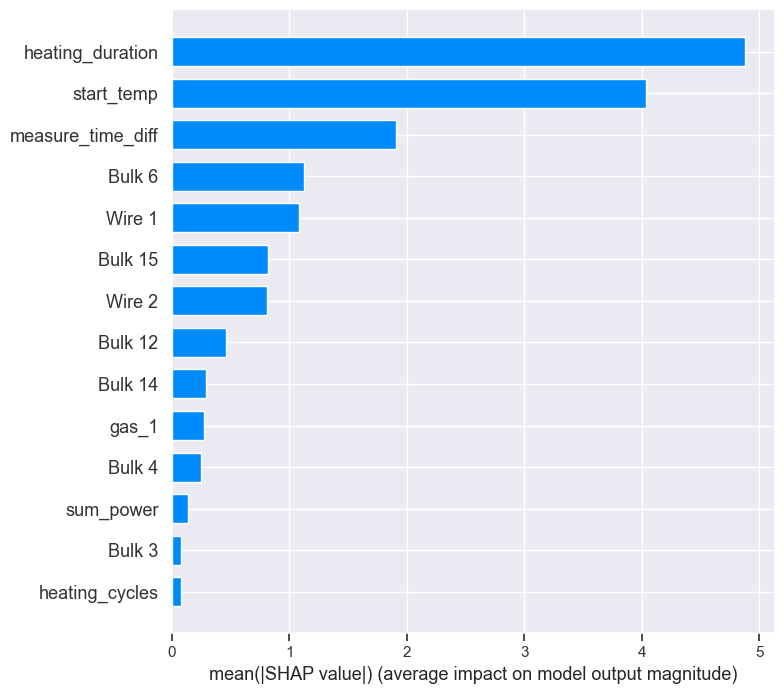

In [97]:
# Построение графика важности признаков
shap.summary_plot(shap_values, X_train, plot_type="bar")

Больше всего на конечную темперутуру влияют:

1. Длительность нагрева(что не удивительно)
2. Начальная температура
3. Разность между измерениями температуры( что несколько дублирует первый параметр)

Далее идут подачи различных материалов. Что удивительно, что суммарная мощность в последней тройке.

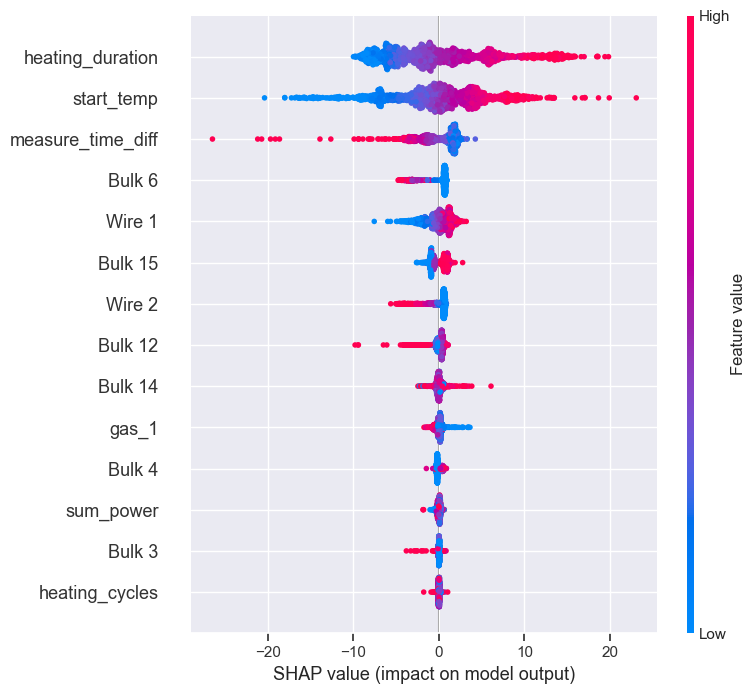

In [98]:
#Сила эффекта каждого признака и направление эффекта
shap.summary_plot(shap_values, X_train)

На графике показаны с какой силой и в какую сторону влияют различные эффекты.
К примеру увеличение времени нагрева и начальной температурой увеличивают и конечную температуру, а меньшее время измерения температур(вследствие очевидно менее продолжительного нагрева) уменьшают финальную температуру.

In [99]:
# Визуализация эффекта для каждого параметра, для каждого интервала
shap.force_plot(explainer.expected_value, shap_values[0:50,:], X_train.iloc[0:50,:])

## Итоговые выводы

1. Данные были загружены и изучены. Была проведена предварительная очистка данных и выделение необходимых признаков.
2. Была проведена обработка пропусков в данных.
3. Таблицы были объединены в одну методом INNER JOIN.
4. Выборки были поделены на обучающую и тестовую в соотношении 75/25.
5. Были созданы новые признаки, а также удалены скоррелированные признаки.
6. Данные были очищены и маштабированы.
7. Были обучены модели машинного обучения. Модели были кросс-валидированы с помощью GridSearch. Была отобрана лучшая модель - StackingCVRegressor(regressors=(Lasso, Ridge, LightGBM), meta_regressor=catboost)
8. Отобранная модель была проверена на адекватность и протестирована на тестовой выборке, МАЕ составило 5.51.
9. Была получена r2-метрика, которая составила 0.55
10. Была изучена важность признаков отобранной модели.

### Описание итоговой модели

Модель: StackingCVRegressor(regressors=(Lasso, Ridge, LightGBM),
                            meta_regressor=catboost)

Гиперпараметры: 
* Lasso (alpha=0.5)
* Ridge (alpha=1)
* catboost (depth=5, iterations=500, learning_rate=0.03)

Random State: 280823

**МАЕ на тестовой выборке:** 5.51